# Setting

In [1]:
import numpy as np
import pandas as pd
import torch
import perceiver #, img_process, text_process

from torch import nn, einsum
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

#from perceiver_pytorch.perceiver_pytorch import exists, default, cache_fn, fourier_encode, PreNorm, FeeodForward, Attention

In [2]:
import matplotlib.pyplot as plt

# Import Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## From here:

In [5]:
MODALITY = 'IMAGE'   # IMAGE/TEXT. 모드 바꾸면 학습 모달리티 바뀜
LOSS_FUNCTION = 'CrossEntropy'  # Loss function. 나중에 이거 전환하는 모드 만들기

TUNING_MODE = 'OFF'  # Hyperparam tuning 모드. 차후 구현

BATCH_SIZE = 32      # TUNING_MODE가 off일 때 기본으로 사용할 batch size, epoch 정의
EPOCH = 15
LR = 0.001
# --- 여기서부턴 데이터 따라서 바꿔야 함 ---
INPUT_DIM = 1
LATENT_DIM = 128
EMBED_DIM = 512
NUM_HEADS = 8
NUM_LAYERS = 4
SEQ_LEN = 100
LATENT_LEN = 10

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# if MODALITY == 'IMAGE':
#     X_train_np, y_train, X_test, y_test = img_process.img_loader()
# else:
#     X_train_np, y_train, X_test, y_test = text_process.language_loader()

# Import Model

## Function

In [8]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1, 1)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total * 100.0
    print(f'Train Epoch: {epoch}\t Loss:{epoch_loss:.4f}\t, Accuracy:{epoch_acc:.3f}')
    return epoch_loss, epoch_acc

In [12]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1, 1)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    epoch_loss = test_loss / len(test_loader.dataset)
    epoch_acc = correct / total * 100.0
    print(f'Test Loss:{epoch_loss:.4f}, Test Acc:{epoch_acc:.3f}%')
    return epoch_loss, epoch_acc

# Train

## Train

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [14]:
model = perceiver.Perceiver(input_dim=INPUT_DIM,
                            latent_dim=LATENT_DIM,
                            embed_dim=EMBED_DIM,
                            num_heads=NUM_HEADS,
                            num_layers=NUM_LAYERS,
                            num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

history_train_loss = []
history_train_acc = []
history_test_loss = []
history_test_acc = []

for epoch in range(1, EPOCH+1):
    loss, acc = train(model, device, train_loader, optimizer, criterion, epoch)
    history_train_loss.append(loss), history_train_acc.append(acc)
    loss, acc = test(model, device, test_loader, criterion)
    history_test_loss.append(loss), history_test_acc.append(acc)

/home/Minju/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Train Epoch: 1	 Loss:2.3364	, Accuracy:10.013
Test Loss:2.3073, Test Acc:10.100%
Train Epoch: 2	 Loss:2.3063	, Accuracy:10.405
Test Loss:2.3108, Test Acc:10.100%
Train Epoch: 3	 Loss:2.3039	, Accuracy:10.483
Test Loss:2.3030, Test Acc:10.280%
Train Epoch: 4	 Loss:2.3032	, Accuracy:10.933
Test Loss:2.3020, Test Acc:11.350%
Train Epoch: 5	 Loss:2.3027	, Accuracy:10.797
Test Loss:2.3017, Test Acc:11.350%
Train Epoch: 6	 Loss:2.3025	, Accuracy:10.900
Test Loss:2.3021, Test Acc:11.350%
Train Epoch: 7	 Loss:2.3022	, Accuracy:10.922
Test Loss:2.3026, Test Acc:11.350%
Train Epoch: 8	 Loss:2.3022	, Accuracy:10.952
Test Loss:2.3011, Test Acc:11.350%
Train Epoch: 9	 Loss:2.3020	, Accuracy:11.112
Test Loss:2.3011, Test Acc:11.350%
Train Epoch: 10	 Loss:2.3021	, Accuracy:11.165
Test Loss:2.3010, Test Acc:11.350%
Train Epoch: 11	 Loss:2.3018	, Accuracy:11.162
Test Loss:2.3012, Test Acc:11.350%
Train Epoch: 12	 Loss:2.3019	, Accuracy:11.152
Test Loss:2.3012, Test Acc:11.350%
Train Epoch: 13	 Loss:2.3

## Learning Curve

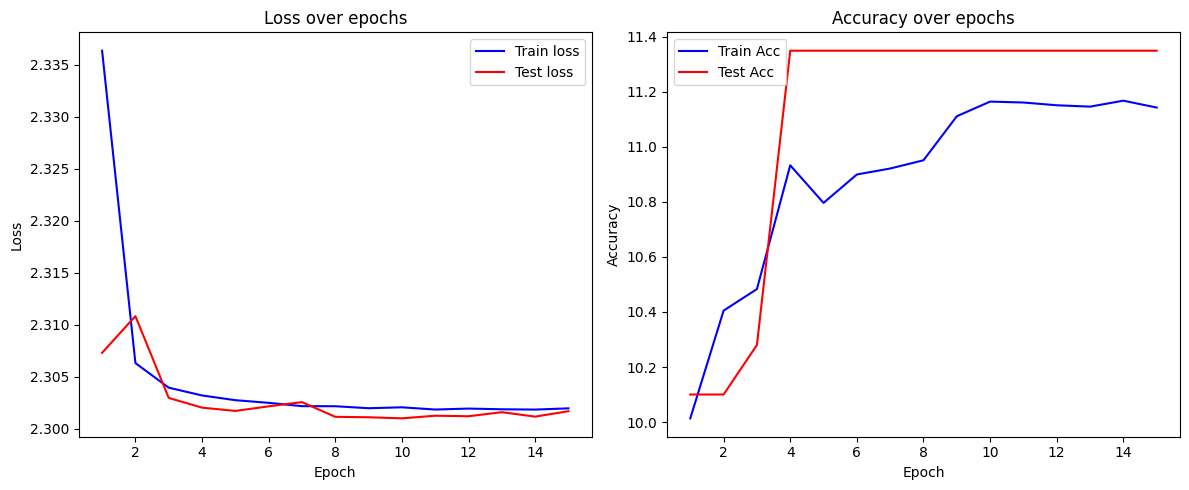

In [15]:
epochs = range(1, EPOCH + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history_train_loss, 'b-', label = 'Train loss')
plt.plot(epochs, history_test_loss, 'r-', label='Test loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_train_acc, 'b-', label = 'Train Acc')
plt.plot(epochs, history_test_acc, 'r-', label='Test Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Load model

In [16]:
torch.save(model.state_dict(), 'perceiver_mnist.pth')
print("모델 저장 완료.")

# 모델 불러오기
model = perceiver.Perceiver(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, embed_dim=EMBED_DIM, 
                 num_heads=NUM_HEADS, num_layers=NUM_LAYERS, num_classes=10).to(device)
model.load_state_dict(torch.load('perceiver_mnist.pth'))
model.eval()
print("모델 불러오기 완료.")

모델 저장 완료.
모델 불러오기 완료.


/tmp/ipykernel_166618/1257665649.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('perceiver_mnist.pth'))
